## `Optimizer`

In [6]:
class Optimizer:
    """Update the Parameters
    
    Args:
        target Union[Model, Layer]: The class which has parameter
        hooks Iterable[function]: Preprocessing the parameter
                                  Used to implement like Weight Decay or Gradient Clipping
    """
    def __init__(self):
        self.target = None
        self.hooks = []
        
    def setup(self, target):
        self.target = target
        return self
    
    def update(self):
        params = [p for p in self.target.params() if p.grad is not None]
        for f in self.hooks:
            f(params)
            
        for param in params:
            self.update_one(param)
            
    def update_one(self, param):
        raise NotImplementedError()
        
    def add_hook(self, f):
        self.hooks.append(f)

## `hook` example!
### `Weight Decay` : If W is 1 and rate is 0.1 then it decay to `1 -> 0.9` before gradient descent!

In [1]:
class WeightDecay:
    def __init__(self, rate):
        self.rate = rate
        
    def __call__(self, params):
        for param in params:
            param.grad.data += self.rate * param.data

### `Gradient Clipping` : Limit the total gradient size.
    - If total gradient size is above chosen gradient size
    - Multiply every gradient at param with..
    
## $rate = \frac{chosen\ gradient\ size}{total\ gradient\ size}$

In [3]:
import math

class ClipGrad:
    def __init__(self, max_norm):
        self.max_norm = max_norm
        
    def __call__(self, params):
        # norm is a size
        total_norm = 0
        for param in params:
            total_norm += (param.grad.data ** 2).sum()
        total_norm = math.sqrt(float(total_norm))
        
        rate = self.max_norm / (total_norm + 1e-6)
        if rate < 1:
            for param in params:
                param.grad.data *= rate

### `Freeze Parameter` : Literally freeze the parameter!

In [ ]:
class FreezeParam:
    def __init__(self, *layers):
        self.freeze_params = []
        for l in layers:
            if isinstance(l, Parameter):
                self.freeze_params.append(l)
            else:
                for p in l.params():
                    self.freeze_params.append(p)
        
    def __call__(self, params):
        for p in self.freeze_params:
            p.grad = None

In case of pytorch it uses `param.requires_grad = False`

In [4]:
class FreezePytorch:
    def __call__(self, params):
        for param in params:
            if param.requires_grad == False:
                param.grad = None

## Implement `SGD` Class 

In [7]:
class SGD(Optimizer):
    def __init__(self, lr=0.01):
        super().__init__()
        self.lr = lr
        
    def update_one(self, param):
        param.data -= self.lr * param.grad.data

## Use `SGD` for `Neural Network`

In [6]:
import numpy as np

from dezero import optimizers
from dezero import Variable

import dezero.functions as F
from dezero.models import MLP

### 1. dataset

In [2]:
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

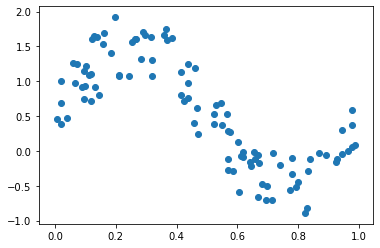

In [3]:
import matplotlib.pyplot as plt

plt.scatter(x, y);

### 2. Model

In [9]:
lr = 0.2
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.SGD(lr).setup(model)

### 3. Train

You can see the `Parameter` administration is held by `Layer`!

In [10]:
iters = 10000

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    optimizer.update()
    
    if i % 1000 == 0:
        print(loss)

Variable(0.8165178492839196)
Variable(0.24990280802148895)
Variable(0.24609876581126014)
Variable(0.23721590814318072)
Variable(0.20793216413350174)
Variable(0.12311905720649353)
Variable(0.07888166506355153)
Variable(0.07655073683421634)
Variable(0.07637803086238225)
Variable(0.07618764131185568)


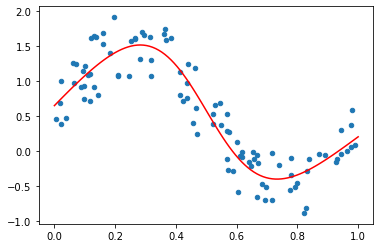

In [11]:
x_test = np.linspace(0, 1, 100).reshape(100, 1)
y_test = model(x_test)
plt.scatter(x, y, s=20)
plt.plot(x_test.data, y_test.data, color='red');

## Implement `SGD Momentum` Class 

In [7]:
class MomentumSGD(Optimizer):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.vs = {}
        
    def update_one(self, param):
        v_key = id(param)
        if v_key not in self.vs:
            self.vs[v_key] = np.zeros_like(param.data)
            
        v = self.vs[v_key]
        v *= self.momentum
        v -= self.lr * param.grad.data
            
        param.data += v

Variable(0.8165178492839196)
Variable(0.07743134827996007)
Variable(0.07544895146731473)
Variable(0.07463260305858643)
Variable(0.07420983776361517)
Variable(0.07397000396385316)
Variable(0.07383179319278564)
Variable(0.0737519831627685)
Variable(0.07370578149495671)
Variable(0.0736788753834185)


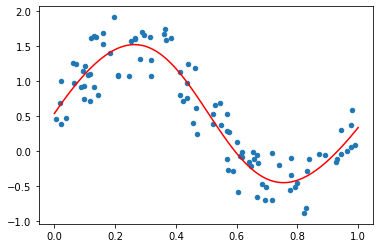

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from dezero import optimizers
from dezero import Variable

import dezero.functions as F
from dezero.models import MLP

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.MomentumSGD(lr).setup(model)

iters = 10000

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    optimizer.update()
    
    if i % 1000 == 0:
        print(loss)
        
x_test = np.linspace(0, 1, 100).reshape(100, 1)
y_test = model(x_test)
plt.scatter(x, y, s=20)
plt.plot(x_test.data, y_test.data, color='red');

## Implement `AdaGrad` Class 

In [ ]:
class AdaGrad(Optimizer):
    def __init__(self, lr=0.001, eps=1e-8):
        super().__init__()
        self.lr = lr
        self.eps = eps
        self.hs = {}
        
    def update_one(self, param):
        h_key = id(param)
        if h_key not in self.hs:
            self.hs[h_key] = np.zeros_like(param.data)
        
        h = self.hs[h_key]
        grad = param.grad.data
        
        h += grad * grad
        param.data -= self.lr * grad / (np.sqrt(h) + self.eps)

Variable(0.8165178492839196)
Variable(0.11840018025339007)
Variable(0.0815218022182982)
Variable(0.07905731786447272)
Variable(0.07755462646457001)
Variable(0.07654778400113071)
Variable(0.07587629422537626)
Variable(0.07540668517351849)
Variable(0.07505508258184954)
Variable(0.07477445307154701)


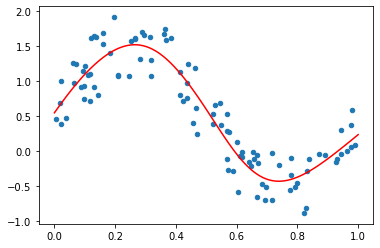

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from dezero import optimizers
from dezero import Variable

import dezero.functions as F
from dezero.models import MLP

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.AdaGrad(lr).setup(model)

iters = 10000

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    optimizer.update()
    
    if i % 1000 == 0:
        print(loss)
        
x_test = np.linspace(0, 1, 100).reshape(100, 1)
y_test = model(x_test)
plt.scatter(x, y, s=20)
plt.plot(x_test.data, y_test.data, color='red');

## Implement `RMSProp` Class 

In [ ]:
class RMSProp(Optimizer):
    def __init__(self, lr=0.001, rho=0.95, eps=1e-8):
        super().__init__()
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.msg = {}
        
    def update_one(self, param):
        key = id(param)
        if key not in self.msg:
            self.msg[key] = np.zeros_like(param.data)
        
        msg = self.msg[key]
        grad = param.grad.data
        
        msg *= self.rho
        msg += (1 - self.rho) * grad * grad
        param.data -= self.lr * grad / (np.sqrt(msg) + self.eps)

Variable(0.8165178492839196)
Variable(0.17008398447067452)
Variable(0.08945788657572809)
Variable(0.08068977387869214)
Variable(0.07856448706651403)
Variable(0.07784918983222852)
Variable(0.07746166040374156)
Variable(0.07715987473711815)
Variable(0.0768898692013273)
Variable(0.07665196383477998)


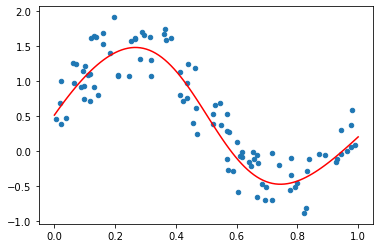

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from dezero import optimizers
from dezero import Variable

import dezero.functions as F
from dezero.models import MLP

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.01
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.RMSProp(lr).setup(model)

iters = 10000

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    optimizer.update()
    
    if i % 1000 == 0:
        print(loss)
        
x_test = np.linspace(0, 1, 100).reshape(100, 1)
y_test = model(x_test)
plt.scatter(x, y, s=20)
plt.plot(x_test.data, y_test.data, color='red');

## Implement `AdaDelta` Class 

In [ ]:
class AdaDelta(Optimizer):
    def __init__(self, lr=0.001, rho=0.95, eps=1e-6):
        super().__init__()
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.msg = {}
        self.msdx = {}
        
    def update_one(self, param):
        key = id(param)
        if key not in self.msg:
            self.msg[key] = np.zeros_like(param.data)
            self.msdx[key] = np.zeros_like(param.data)
            self.msdx[key] += self.lr
        
        msg, msdx = self.msg[key], self.msdx[key]
        grad = param.grad.data
        
        msg *= self.rho
        msg += (1 - self.rho) * grad * grad
        
        dx = np.sqrt((msdx + self.eps) / (msg + self.eps)) * grad
        msdx *= self.rho
        msdx += (1 - self.rho) * dx * dx
        
        param.data -= dx

Variable(0.8165178492839196)
Variable(0.10125725407787706)
Variable(0.09942894478138081)
Variable(0.09734914309612254)
Variable(0.09517772405112437)
Variable(0.09312099244983484)
Variable(0.0911071809685496)
Variable(0.08916478266010923)
Variable(0.08736154315330898)
Variable(0.08575396133156271)


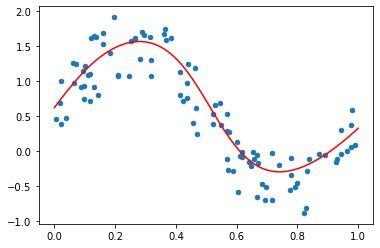

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dezero import optimizers
from dezero import Variable

import dezero.functions as F
from dezero.models import MLP

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.01
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.AdaDelta(lr).setup(model)

iters = 10000

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    optimizer.update()
    
    if i % 1000 == 0:
        print(loss)
        
x_test = np.linspace(0, 1, 100).reshape(100, 1)
y_test = model(x_test)
plt.scatter(x, y, s=20)
plt.plot(x_test.data, y_test.data, color='red');

## Implement `Adam` Class 

In [ ]:
class Adam(Optimizer):
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__()
        self.t = 0
        self.alpha = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.ms = {}
        self.vs = {}
        
    def update(self, *args, **kwargs):
        self.t += 1
        super().update(*args, **kwargs)
        
    @property
    def lr(self):
        fix1 = 1. - math.pow(self.beta1, self.t)
        fix2 = 1. - math.pow(self.beta2, self.t)
        return self.alpha * math.sqrt(fix2) / fix1
        
    def update_one(self, param):
        key = id(param)
        if key not in self.ms:
            self.ms[key] = np.zeros_like(param.data)
            self.vs[key] = np.zeros_like(param.data)
        
        m, v = self.ms[key], self.vs[key]
        beta1, beta2, eps = self.beta1, self.beta2, self.eps
        grad = param.grad.data
        
        m *= beta1
        m += (1 - beta1) * grad
        
        v *= beta2
        v += (1 - beta2) * grad * grad
        
        m_hat = m / (1 - beta1)
        v_hat = v / (1 - beta2)
        
        param.data -= self.lr * m_hat / (np.sqrt(v_hat) + eps)

### `lr` might be tricky! let's check the value of it! 

array([  1.25892541,   1.46391965,   1.70229366,   1.97948276,
         2.30180731,   2.67661685,   3.11245763,   3.61926756,
         4.20860272,   4.89390092,   5.69078809,   6.61743456,
         7.69496939,   8.94796214,  10.4049831 ,  12.09925474,
        14.06940923,  16.36036933,  19.02437267,  22.12216291,
        25.72437474,  29.9131445 ,  34.78398302,  40.44795338,
        47.03420342,  54.69291042,  63.59870548,  73.95465531,
        85.99689257, 100.        ])

In [18]:
import math
import numpy as np

beta1 = 0.9
beta2 = 0.999

for t in np.logspace(0.1, 3.5, 30):
    t = math.floor(t)
    fix1 = 1. - math.pow(beta1, t)
    fix2 = 1. - math.pow(beta2, t)
    print('Correction value of learning rate(alpha) at ', t, ' time : ', math.sqrt(fix2) / fix1)

Correction value of learning rate(alpha) at  1  time :  0.3162277660168381
Correction value of learning rate(alpha) at  1  time :  0.3162277660168381
Correction value of learning rate(alpha) at  2  time :  0.23531672532745276
Correction value of learning rate(alpha) at  2  time :  0.23531672532745276
Correction value of learning rate(alpha) at  3  time :  0.2020105974389679
Correction value of learning rate(alpha) at  4  time :  0.18376892374498519
Correction value of learning rate(alpha) at  6  time :  0.16510815268402332
Correction value of learning rate(alpha) at  8  time :  0.15677125516997972
Correction value of learning rate(alpha) at  10  time :  0.1531890739511824
Correction value of learning rate(alpha) at  14  time :  0.15292149570034197
Correction value of learning rate(alpha) at  18  time :  0.1571889208164824
Correction value of learning rate(alpha) at  24  time :  0.16738414558161668
Correction value of learning rate(alpha) at  32  time :  0.1838193067048081
Correction va

Variable(0.8165178492839196)
Variable(0.2442930060459918)
Variable(0.22366191990640907)
Variable(0.09956874087956519)
Variable(0.07559762941297682)
Variable(0.07459680980530814)
Variable(0.07414770660919734)
Variable(0.07395210406895047)
Variable(0.07383193179795274)
Variable(0.07375649532896796)


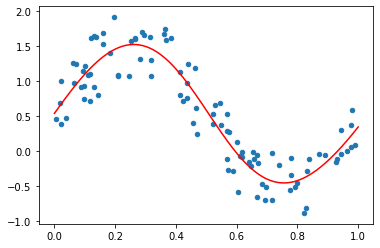

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dezero import optimizers
from dezero import Variable

import dezero.functions as F
from dezero.models import MLP

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.01
hidden_size = 10

model = MLP((hidden_size, 1))
optimizer = optimizers.Adam(lr).setup(model)

iters = 10000

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    optimizer.update()
    
    if i % 1000 == 0:
        print(loss)
        
x_test = np.linspace(0, 1, 100).reshape(100, 1)
y_test = model(x_test)
plt.scatter(x, y, s=20)
plt.plot(x_test.data, y_test.data, color='red');